In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### 1. Optical flow

- Optical Flow dùng để ước lượng vật thể dịch chuyển giữa 2 khung hình liên tiếp của 1 video
- Bao gồm:
    - Dense Optical Flow: Mọi pixel sẽ được tracked sử dụng Gunnar Farneback
    - Sparse Optical Flow: Feature tracked bằng Lucas-Kanade

#### 1.1. Lucas Kanade Method

Sử dụng local assumption để tính toán Optical flow: Giả định rằng các điểm ảnh lân cận có cùng chuyển động -> Nhóm thành các winSize 3x3, 5x5, ...

Dựa trên giả thuyết quang học người ta đưa ra công thức:
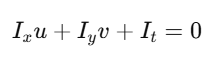

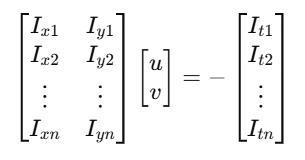

- Ưu điểm:  Nhanh, chính xác với các chuyển động nhỏ.
- Nhược điểm: Không chính xác với các vùng không đủ đặc trưng, Bị nhiễu nếu thay đổi cường độ sáng hoặc biến dạng hình học

In [ ]:
# Chạy thử knop.py trong python file

cap = cv2.VideoCapture('C:/Users/DELL/PycharmProjects/DL/ATV_Training/2_OpenCV/data/car.mp4')

ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

p0 = cv2.goodFeaturesToTrack(old_gray, maxCorners=100, qualityLevel=0.03, minDistance=10, blockSize=7)

lk_params = dict(winSize=(15, 15), maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

mask = np.zeros_like(old_frame)

while ret:
    ret, frame = cap.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    good_new = p1[st == 1]
    good_old = p0[st == 1]

    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
        frame = cv2.circle(frame, (int(a), int(b)), 5, (0, 0, 255), -1)

    img = cv2.add(frame, mask)
    cv2.imshow('Lucas-Kanade Optical Flow', img)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

cap.release()
cv2.destroyAllWindows()

#### 1.2. Dense optical flow

In [9]:
cap = cv2.VideoCapture('C:/Users/DELL/PycharmProjects/DL/ATV_Training/2_OpenCV/data/car.mp4')

ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

while(1):
    ret, frame2 = cap.read()
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    cv2.imshow('frame2',rgb)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv2.imwrite('opticalfb.png',frame2)
        cv2.imwrite('opticalhsv.png',rgb)
    prvs = next

cap.release()
cv2.destroyAllWindows()

### 2. Background Subtraction

Background subtraction là một kỹ thuật giúp tách vật thể chuyển động (foreground) ra khỏi nền tĩnh (background) trong video.

#### 2.1. BackgroundSubtractorMOG

Nó sử dụng 1 method mô hình hoá background bằng 1 mixture của K Gaussian distribution (K từ 3 đến 5). Trước tiên cần tạo background object bằng hàm cv2.createBackgroundSubtractorMOG(), sau đó trong quá trình loop dùng backgroundsubtractor.apply() để tìm foreground mask. Do OpenCV đã không còn available hàm này nên chuyển sang MOG2.

#### 2.2 BackgroundSubtractorMOG2
Là bản cải tiến MOG, nó sẽ chọn số Gaussian distribution phù hợp cho mỗi pixel tạo nên hiệu quả tốt hơn khi cập nhật nền động thay vì fix cứng số K như MOG

In [ ]:
# Chạy thử mog2.py trong python_file
fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows=True) 

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    fgmask = fgbg.apply(frame)

    cv2.imshow("Foreground Mask", fgmask)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

#### 2.3. BackgroundSubtractorKNN
Sử dụng thuật toán KNN để phân loại background và foreground giúp ổn định hơn so với MOG2 trong điều kiện môi trường thay đổi phức tạp

In [ ]:
fgbg = cv2.createBackgroundSubtractorKNN()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    fgmask = fgbg.apply(frame)

    cv2.imshow("Foreground Mask", fgmask)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()